In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchsummary import summary

import zipfile

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = "/content/drive/MyDrive/swan_detection/swan_detection.zip"
z = zipfile.ZipFile(zip_file, "r")
z.extractall()

# Make dataset

In [ ]:
klikun_images = os.listdir("classification_images/images/klikun")
malyi_images = os.listdir("classification_images/images/malyi")
shipun_images = os.listdir("classification_images/images/shipun")

In [ ]:
klikun_images_path = [f"classification_images/images/klikun/{x}" for x in klikun_images]
malyi_images_path = [f"classification_images/images/malyi/{x}" for x in malyi_images]
shipun_images_path = [f"classification_images/images/shipun/{x}" for x in shipun_images]

In [ ]:
print(len(klikun_images_path))
print(len(malyi_images_path))
print(len(shipun_images_path))

3025
3002
3011


In [ ]:
# remove images with number of channels != 3
def clean_images(images_path):
  images_path_clean = []
  for path_img in images_path:
    to_tensor = A.Compose([ToTensorV2()])
    image = to_tensor(image = np.array(Image.open(path_img)))
    n_ch = image['image'].shape[0]
    if n_ch==3:
      images_path_clean.append(path_img)
    else:
      print(path_img)
  return images_path_clean

In [ ]:
klikun_images_path = clean_images(klikun_images_path)
malyi_images_path = clean_images(malyi_images_path)
shipun_images_path = clean_images(shipun_images_path)

classification_images/images/malyi/img_75.jpg
classification_images/images/malyi/img_79.jpg
classification_images/images/malyi/img_62.jpg
classification_images/images/malyi/img_83.jpg
classification_images/images/malyi/img_64.jpg
classification_images/images/malyi/img_65.jpg
classification_images/images/malyi/img_54.jpg
classification_images/images/malyi/img_88.jpg
classification_images/images/malyi/img_59.jpg
classification_images/images/malyi/img_63.jpg
classification_images/images/malyi/img_71.jpg
classification_images/images/malyi/img_82.jpg
classification_images/images/malyi/img_85.jpg
classification_images/images/malyi/img_58.jpg
classification_images/images/malyi/img_74.jpg
classification_images/images/malyi/img_81.jpg
classification_images/images/malyi/img_73.jpg
classification_images/images/malyi/img_72.jpg
classification_images/images/malyi/img_80.jpg
classification_images/images/malyi/img_55.jpg
classification_images/images/malyi/img_56.jpg
classification_images/images/malyi

In [ ]:
print(len(klikun_images_path))
print(len(malyi_images_path))
print(len(shipun_images_path))

3025
2961
3010


In [ ]:
klikun_images_labels = [(x,0) for x in klikun_images_path]
malyi_images_labels = [(x,1) for x in malyi_images_path]
shipun_images_labels = [(x,2) for x in shipun_images_path]

In [ ]:
data = klikun_images_labels + malyi_images_labels + shipun_images_labels

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.2)

In [ ]:
data_train, data_val = train_test_split(data_train, test_size=0.125)

In [ ]:
class CustomImageFolder(torch.utils.data.Dataset):
  def __init__(self, data, transformer=None):
    self.data = data
    self.transformer = transformer

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
      image_filename = self.data[idx][0]
      label = self.data[idx][1]

      image = np.array(Image.open(image_filename))

      if self.transformer:
        transformed = self.transformer(image=image)
        image = transformed['image']
      return image, label

In [ ]:
proba = 0.3
train_transform = A.Compose([ A.Resize(272, 272, always_apply=True),
                              A.RandomFog(p=proba),
                              A.RandomShadow(p=proba),
                              A.RandomBrightnessContrast(p=proba),
                              A.Blur(blur_limit = 5, p = proba),
                              A.HorizontalFlip(p=proba),
                              A.VerticalFlip(p=proba),
                              A.Rotate(limit=[-60,60], p=proba),
                              A.Normalize(),
                              ToTensorV2(),], is_check_shapes=False)
val_transform = A.Compose([A.Resize(272, 272, always_apply=True),
                           A.Normalize(),
                           ToTensorV2(),], is_check_shapes=False)

In [ ]:
dataset_train = CustomImageFolder(data_train, train_transform)
dataset_val = CustomImageFolder(data_val, val_transform)
dataset_test = CustomImageFolder(data_test, val_transform)

In [ ]:
from torchvision.transforms.functional import to_pil_image
def plot_image(image: torch.tensor,label: int):
  image = to_pil_image(image)
  plt.imshow(image)
  plt.title(f"label: {label}")
  plt.show()

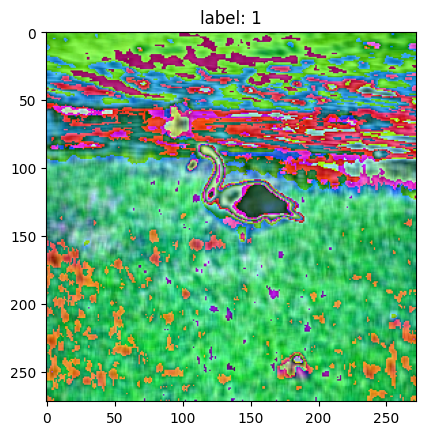

In [ ]:
plot_image(dataset_train[0][0], dataset_train[0][1])

# Make DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=16, shuffle=True)

NameError: ignored

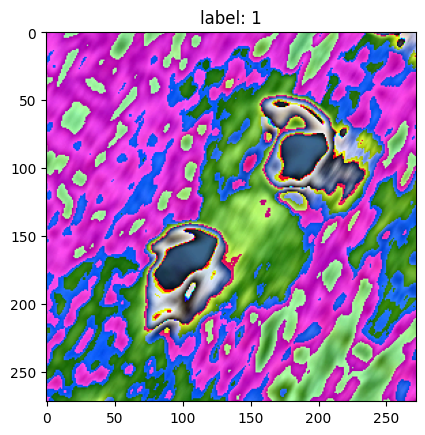

In [ ]:
for im,l in train_dataloader:
  plot_image(im[5], l[5])
  break

In [ ]:
import torch.nn as nn
from torchvision import models

# Convolutional Model

In [ ]:
class ConvModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(3,16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2),
        nn.Conv2d(16,16,kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(16,32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32,32,kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25)
    )
    self.block3 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64,64,kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25)
    )
    self.block4 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128,128,kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25)
    )
    self.FC = nn.Sequential(
        nn.Flatten(),
        nn.Linear(36992,512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Dropout1d(p=0.25),
        nn.Linear(512,3)
    )

  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    out = self.FC(x)
    return out

In [ ]:
device = "cpu"
model = ConvModel()
model = model.to(device)
summary(model, (3, 272, 272))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 272, 272]             448
       BatchNorm2d-2         [-1, 16, 272, 272]              32
         LeakyReLU-3         [-1, 16, 272, 272]               0
            Conv2d-4         [-1, 16, 272, 272]           2,320
       BatchNorm2d-5         [-1, 16, 272, 272]              32
         LeakyReLU-6         [-1, 16, 272, 272]               0
         MaxPool2d-7         [-1, 16, 136, 136]               0
         Dropout2d-8         [-1, 16, 136, 136]               0
            Conv2d-9         [-1, 32, 136, 136]           4,640
      BatchNorm2d-10         [-1, 32, 136, 136]              64
        LeakyReLU-11         [-1, 32, 136, 136]               0
           Conv2d-12         [-1, 32, 136, 136]           9,248
      BatchNorm2d-13         [-1, 32, 136, 136]              64
        LeakyReLU-14         [-1, 32, 1

# Training Functions

In [ ]:
from tqdm.notebook import tqdm, trange
def train_epoch(train_loader, model, optimizer, criterion, device, epoch):
  model.train()
  pbar = tqdm(enumerate(train_loader), total=len(train_loader))
  loss_list = []
  for i, (images, labels) in pbar:
    labels = labels.to(device)
    images = images.to(device)
    optimizer.zero_grad()
    outputs = torch.sigmoid(model(images))
    loss=criterion(outputs.to(torch.float64), labels)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    pbar.set_description(
        f"Train Loss {epoch}: {round(np.sum(loss_list),2)}"
     )
  return np.round(np.sum(loss_list),1)

def valid(val_loader, model, criterion, device, epoch):
  model.eval()
  acc_list = []
  loss_list = []
  acc = 0
  pbar = tqdm(enumerate(val_loader), total=len(val_loader))
  with torch.no_grad():
    for i, (images, labels) in pbar:
      images = images.to(device)
      labels = labels.to(device)

      outputs = torch.sigmoid(model(images))
      loss=criterion(outputs.to(torch.float64), labels)

      soft = nn.Softmax()
      outputs = torch.argmax(soft(outputs),dim = 1)
      acc += (outputs == labels).float().sum().cpu()

      acc_list.append(acc.item())
      loss_list.append(loss.item())

      pbar.set_description(
          f"Valid Loss {epoch}: {round(np.sum(loss_list),2)}"
          f"Accuracy: {np.round(acc/len(val_loader.dataset)*100,2)}%"
      )
  acc_out = np.round(acc/len(val_loader.dataset)*100,2).numpy()
  return (np.round(np.sum(loss_list),1), acc_out)


In [ ]:
def plot_loss(train_loss_list, val_loss_list):
  fig, ax = plt.subplots(1,2, figsize=(16,5))
  ax[0].plot(np.arange(1,len(train_loss_list)+1),train_loss_list, linestyle="--", c="grey")
  ax[0].scatter(np.arange(1,len(train_loss_list)+1),train_loss_list, c="red")
  ax[0].set_xlabel("epoch")
  ax[0].set_title("Train loss")
  ax[0].set_ylabel("Loss")
  ax[0].set_ylim([150,450])
  ax[0].grid()

  ax[1].plot(np.arange(1,len(val_loss_list)+1),val_loss_list, linestyle="--", c="black")
  ax[1].scatter(np.arange(1,len(val_loss_list)+1),val_loss_list, c="red")
  ax[1].set_xlabel("valid epoch (each 2 train epoch)")
  ax[1].set_title("Valid loss")
  ax[1].set_ylabel("Loss")
  ax[1].set_ylim([10,50])
  ax[1].grid()

  plt.show()

def plot_metrics(val_acc_list):
  fig, ax = plt.subplots(1,1, figsize=(16,5))
  ax.plot(np.arange(1,len(val_acc_list)+1),val_acc_list,c="gray", linestyle="--")
  ax.scatter(np.arange(1,len(val_acc_list)+1),val_acc_list, c="red")
  ax.set_xlabel("valid epoch (each 2 train epoch)")
  ax.set_ylabel("Accuracy")
  ax.set_title("Valid Accuracy")
  ax.set_ylim([40,100])
  ax.grid()

# ConvModel training

In [ ]:
device = "cuda"
model = ConvModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
n_epoch = 2
for epoch in np.arange(n_epoch):
  train_loss = train_epoch(train_dataloader, model, optimizer, criterion, device, epoch)
  train_loss_list.append(train_loss)

  if epoch%2 ==1:
    val_loss, val_acc= valid(val_dataloader, model, criterion, device, epoch)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

<ipython-input-114-bb86840a5c71>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.argmax(soft(outputs),dim = 1)


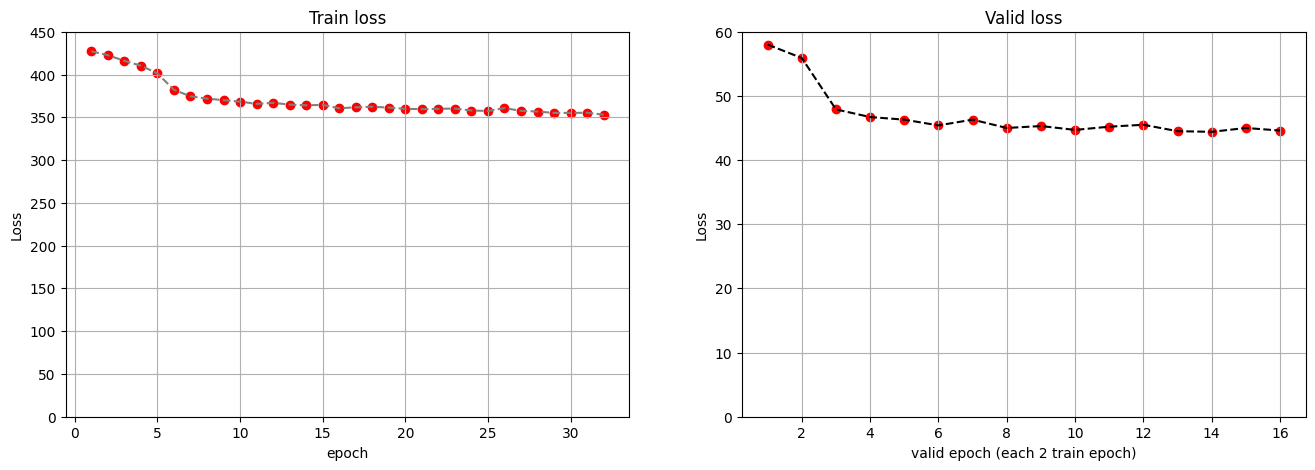

In [ ]:
plot_loss(np.round(train_loss_list,1), np.round(val_loss_list,1))

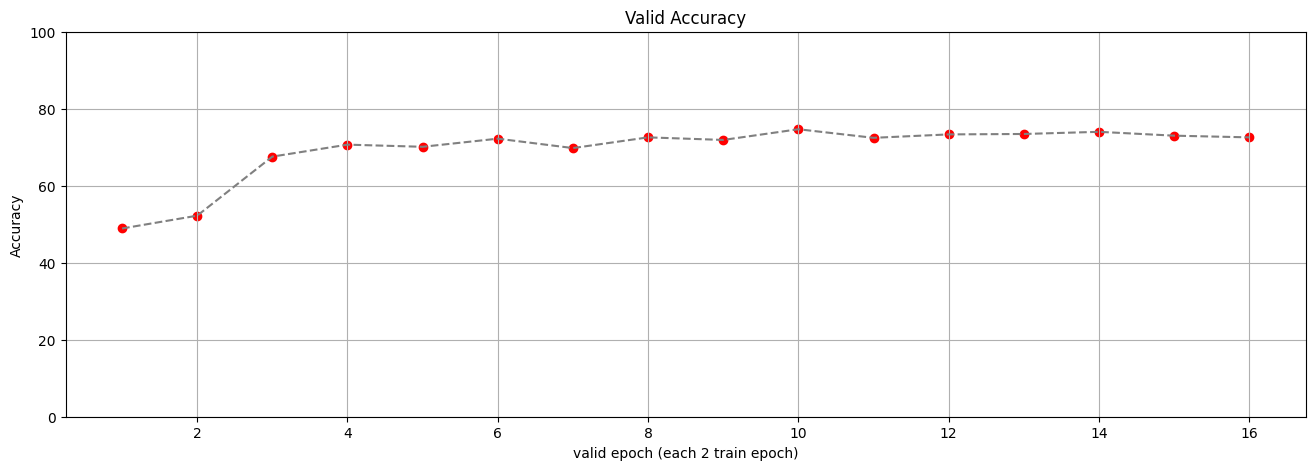

In [ ]:
plot_metrics(val_acc_list)

In [ ]:
train_loss_str = list(map(str, train_loss_list))
val_loss_str = list(map(str, val_loss_list))
val_acc_str = list(map(str, val_acc_list))

In [ ]:
with open("conv_metrics.txt", "w") as file:
  train_loss = " ".join(train_loss_str)
  train_loss = f"train_loss: {train_loss} \n"
  file.write(train_loss)

  val_loss = " ".join(val_loss_str)
  val_loss = f"val_loss: {val_loss} \n"
  file.write(val_loss)

  val_acc = " ".join(val_acc_str)
  val_acc = f"val_acc: {val_acc}"
  file.write(val_acc)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/swan_detection/conv_model.pth") # epoch 32

In [ ]:
! cp conv_metrics.txt /content/drive/MyDrive/swan_detection/

# ConvModel Test

In [ ]:
def test_model(test_dataloader, model, criterion, device):
  _, test_acc = valid(test_dataloader, model, criterion, device,1)
  print("Test acc:", test_acc)
  return test_acc

In [ ]:
conv_model = ConvModel().to(device)
conv_model.load_state_dict(torch.load('/content/drive/MyDrive/swan_detection/conv_model.pth'))

<All keys matched successfully>

In [ ]:
test_accuracy = test_model(test_dataloader, conv_model, criterion, device)

  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 73.5


In [ ]:
print("Test accuracy ConvModel: ", test_accuracy,"%")

Test accuracy ConvModel:  73.5 %


# My ResNetModel

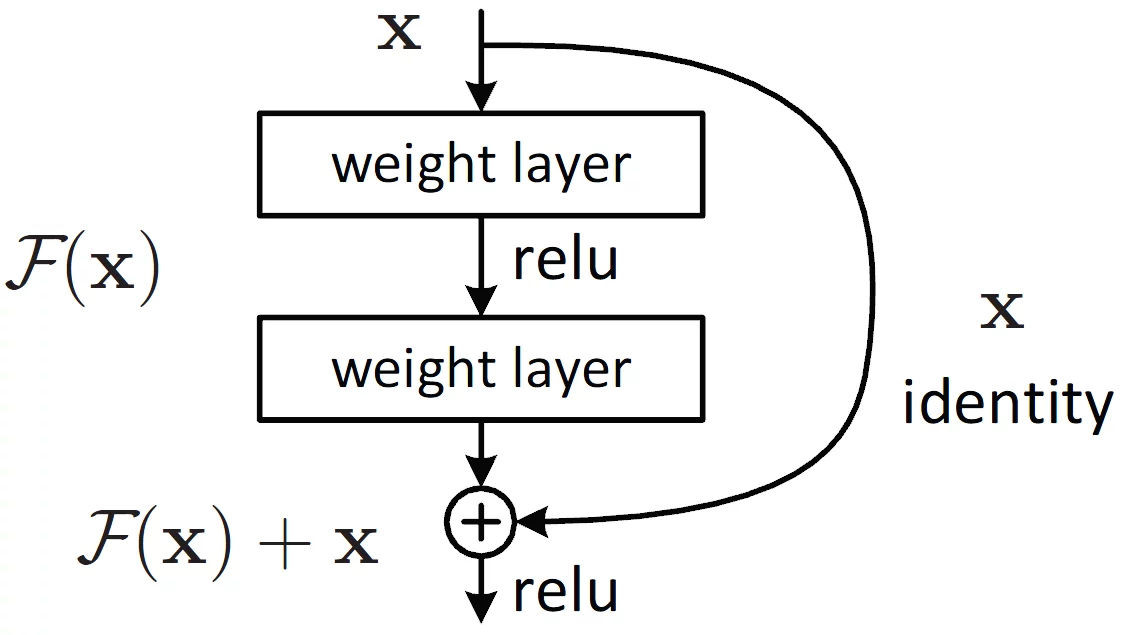

In [ ]:
class Block(nn.Module):
  def __init__(self,num_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(num_ch,num_ch,kernel_size = 3,padding = 1)
    self.bn1 = nn.BatchNorm2d(num_ch)
    self.conv2 = nn.Conv2d(num_ch,num_ch,kernel_size = 3,padding = 1)
    self.bn2 = nn.BatchNorm2d(num_ch)

    self.act = nn.LeakyReLU(0.2,inplace = True)

  def forward (self,x):
    out = self.act(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(x))
    return self.act(x + out)

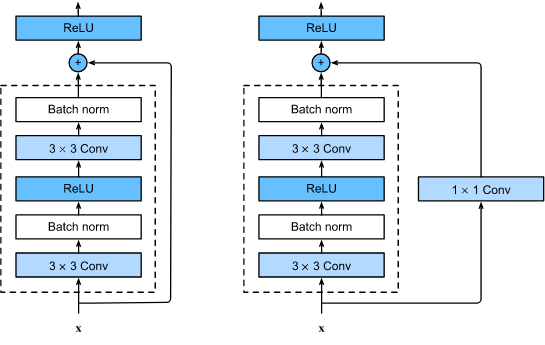

In [ ]:
class IdentityBlock(nn.Module): # 1x1 Conv on picture above; --->--- line on picture below
  def __init__(self,num_in,num_out):
    super().__init__()
    self.conv_identity = nn.Conv2d(num_in,num_out,1,stride = 2)
    self.bn = nn.BatchNorm2d(num_out)

    self.conv1 = nn.Conv2d(num_in,num_out,3,padding = 1, stride = 2)
    self.bn1 = nn.BatchNorm2d(num_out)
    self.conv2 = nn.Conv2d(num_out,num_out,3,padding = 1)
    self.bn2 = nn.BatchNorm2d(num_out)
    self.act = nn.LeakyReLU(0.2)

  def forward(self,x):
    x1 = self.bn(self.conv_identity(x))

    x2 = self.act(self.bn1(self.conv1(x)))
    x2 = self.bn2(self.conv2(x2))

    return self.act(x1 + x2)

In [ ]:
class BlockTruck(nn.Module): # blocks with same color on picture below
  def __init__(self,num_blocks,num_ch):
    super().__init__()
    truck_list = [Block(num_ch) for i in np.arange(num_blocks)]
    self.truck = nn.Sequential(*truck_list)
  def forward(self,x):
    out = self.truck(x)
    return out

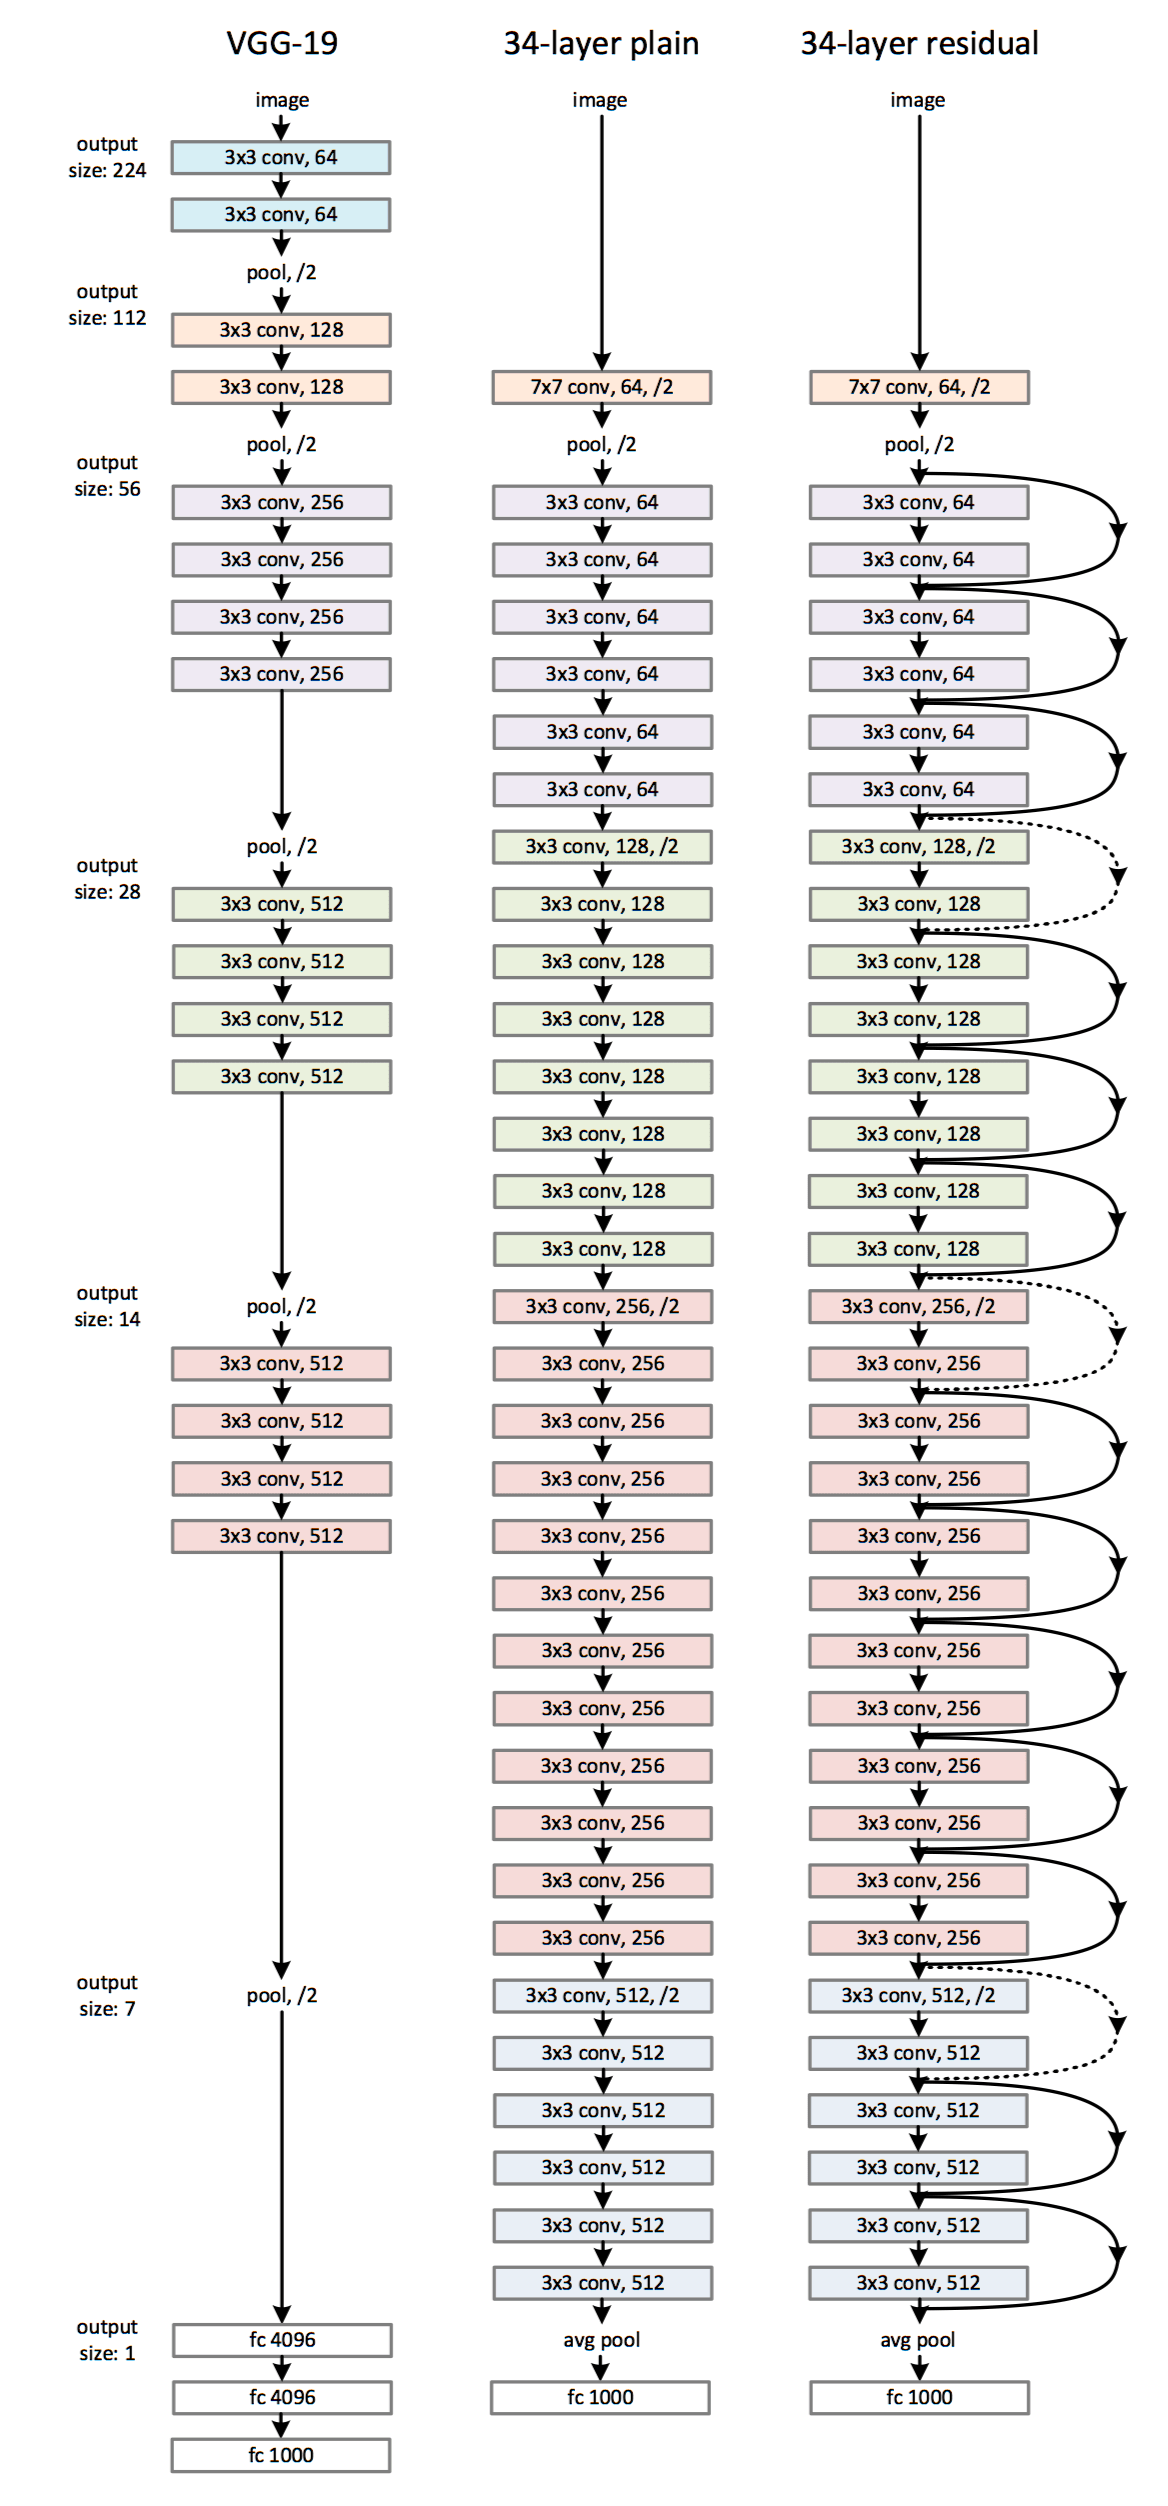

In [ ]:
# Like ResNet 34, but shorter!
class MyResNet(nn.Module):
  def __init__(self,cl_num):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding = 1)
    self.act = nn.LeakyReLU(0.2)
    self.mpool = nn.MaxPool2d(2)

    self.layer1 = nn.Sequential(
        BlockTruck(3,16),
        IdentityBlock(16,32)
    )
    self.layer2 = nn.Sequential(
        BlockTruck(4,32),
        IdentityBlock(32,64)
    )
    self.layer3 = nn.Sequential(
        BlockTruck(5,64)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.flat = nn.Flatten()
    self.bn = nn.BatchNorm1d(64)
    self.linear = nn.Linear(64,cl_num)
  def forward(self,x):
    out = self.mpool(self.act(self.conv1(x)))

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)

    out = self.avgpool(out)

    out = self.flat(out)
    out = self.linear(self.bn(out))

    return out

In [ ]:
device = "cuda"
resnet_model = MyResNet(cl_num=3).to(device)
summary(resnet_model, (3, 272, 272))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 272, 272]             448
         LeakyReLU-2         [-1, 16, 272, 272]               0
         MaxPool2d-3         [-1, 16, 136, 136]               0
            Conv2d-4         [-1, 16, 136, 136]           2,320
       BatchNorm2d-5         [-1, 16, 136, 136]              32
         LeakyReLU-6         [-1, 16, 136, 136]               0
            Conv2d-7         [-1, 16, 136, 136]           2,320
       BatchNorm2d-8         [-1, 16, 136, 136]              32
         LeakyReLU-9         [-1, 16, 136, 136]               0
            Block-10         [-1, 16, 136, 136]               0
           Conv2d-11         [-1, 16, 136, 136]           2,320
      BatchNorm2d-12         [-1, 16, 136, 136]              32
        LeakyReLU-13         [-1, 16, 136, 136]               0
           Conv2d-14         [-1, 16, 1

# MyResNet training

In [ ]:
'''
resnet_model = MyResNet(cl_num=3).to(device)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

resnet_train_loss_list = []
resnet_val_loss_list = []
resnet_val_acc_list = []

In [ ]:
n_epoch = 2
for epoch in np.arange(n_epoch):
  train_loss = train_epoch(train_dataloader, resnet_model, optimizer, criterion, device, epoch)
  resnet_train_loss_list.append(train_loss)
  #scheduler.step()
  #print("learning rate:", optimizer.param_groups[0]["lr"])
  if epoch%2 ==1:
    val_loss, val_acc= valid(val_dataloader, resnet_model, criterion, device, epoch)
    resnet_val_loss_list.append(val_loss)
    resnet_val_acc_list.append(val_acc)

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

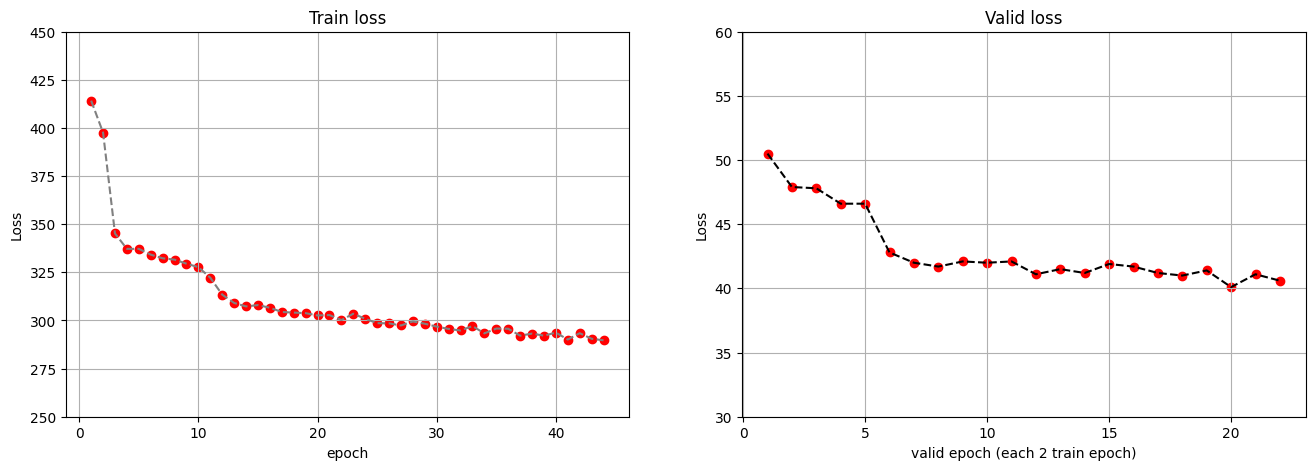

In [ ]:
plot_loss(np.round(resnet_train_loss_list,1), np.round(resnet_val_loss_list,1))

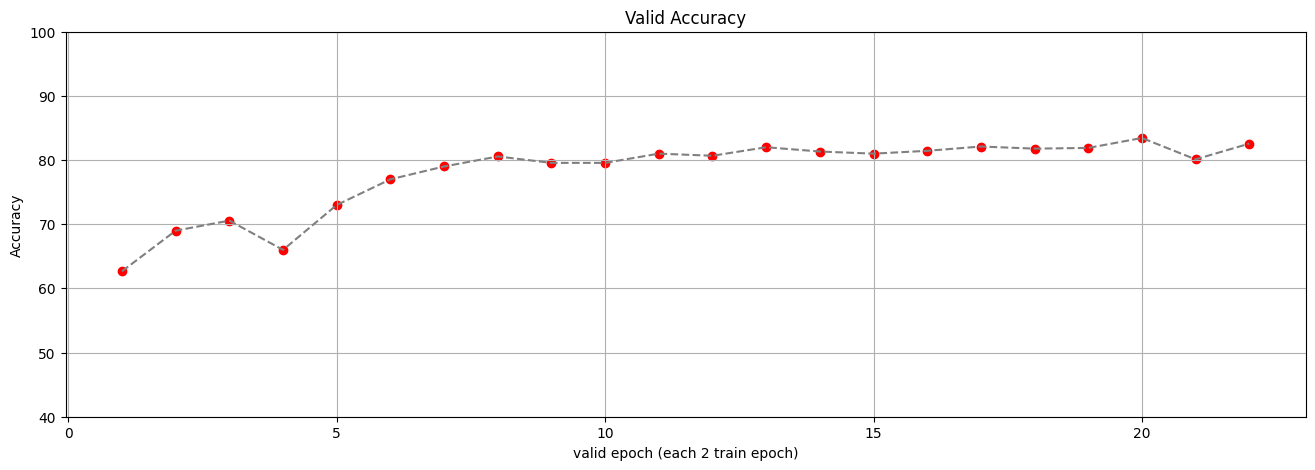

In [ ]:
plot_metrics(resnet_val_acc_list)

In [ ]:
resnet_train_loss_str = list(map(str, resnet_train_loss_list))
resnet_val_loss_str = list(map(str, resnet_val_loss_list))
resnet_val_acc_str = list(map(str, resnet_val_acc_list))

In [ ]:
with open("my_resnet_metrics.txt", "w") as file:
  train_loss = " ".join(resnet_train_loss_str)
  train_loss = f"train_loss: {train_loss} \n"
  file.write(train_loss)

  val_loss = " ".join(resnet_val_loss_str)
  val_loss = f"val_loss: {val_loss} \n"
  file.write(val_loss)

  val_acc = " ".join(resnet_val_acc_str)
  val_acc = f"val_acc: {val_acc}"
  file.write(val_acc)

In [ ]:
! cp my_resnet_metrics.txt /content/drive/MyDrive/swan_detection/

In [ ]:
#torch.save(resnet_model.state_dict(), "/content/drive/MyDrive/swan_detection/my_resnet_model.pth") # epoch 40

<h2> Take epoch 40 </h2>

# Test MyResNet

In [ ]:
device="cuda"
resnet_model = MyResNet(3).to(device)
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/swan_detection/my_resnet_model.pth'))

<All keys matched successfully>

In [ ]:
test_accuracy = test_model(test_dataloader, resnet_model, criterion, device)

  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 83.5


# Pretrained ResNet34

<h2> Input image size of resnet34: 224x224!!

In [ ]:
proba = 0.3
train_transform_resnet34 = A.Compose([ A.Resize(224, 224, always_apply=True),
                              A.RandomFog(p=proba),
                              A.RandomShadow(p=proba),
                              A.RandomBrightnessContrast(p=proba),
                              A.Blur(blur_limit = 5, p = proba),
                              A.HorizontalFlip(p=proba),
                              A.VerticalFlip(p=proba),
                              A.Rotate(limit=[-60,60], p=proba),
                              A.Normalize(),
                              ToTensorV2(),], is_check_shapes=False)
val_transform_resnet34 = A.Compose([A.Resize(224, 224, always_apply=True),
                           A.Normalize(),
                           ToTensorV2(),], is_check_shapes=False)

In [ ]:
dataset_train_resnet34 = CustomImageFolder(data_train, train_transform_resnet34)
dataset_val_resnet34 = CustomImageFolder(data_val, val_transform_resnet34)
dataset_test_resnet34 = CustomImageFolder(data_test, val_transform_resnet34)

In [ ]:
train_dataloader_resnet34 = DataLoader(dataset_train_resnet34, batch_size=16, shuffle=True)
test_dataloader_resnet34 = DataLoader(dataset_test_resnet34, batch_size=16, shuffle=True)
val_dataloader_resnet34 = DataLoader(dataset_val_resnet34, batch_size=16, shuffle=True)

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

In [ ]:
device = "cuda"
model_pretrained = resnet34(weights = ResNet34_Weights.DEFAULT).to(device)
model_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for p in model_pretrained.parameters():
  p.require_grad = False

In [ ]:
num_cl = 3
linear_clf = nn.Sequential(
    nn.Linear(512,256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Linear(256,num_cl)
    )
#model_pretrained.fc = linear_clf

In [ ]:
for p in model_pretrained.layer4.parameters():
  p.requires_grad = True

for p in model_pretrained.layer3.parameters():
  p.requires_grad = True

In [ ]:
model_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Pretrained ResNet34 Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([{"params" : model_pretrained.fc.parameters()},
                               {"params" : model_pretrained.layer4.parameters(), 'lr' : 10**(-4)}
                              {"params" : model_pretrained.layer3.parameters(), 'lr' : 10**(-5)}
                              ],lr = 10**(-3))
resnet_pretrained_train_loss_list = []
resnet_pretrained_val_loss_list = []
resnet_pretrained_val_acc_list = []
model_pretrained = model_pretrained.to(device)

In [ ]:
n_epoch = 2
for epoch in np.arange(n_epoch):
  train_loss = train_epoch(train_dataloader_resnet34, model_pretrained, optimizer, criterion, device, epoch)
  resnet_pretrained_train_loss_list.append(train_loss)
  #scheduler.step()
  #print("learning rate:", optimizer.param_groups[0]["lr"])
  if epoch%2 ==1:
    val_loss, val_acc= valid(val_dataloader_resnet34, model_pretrained, criterion, device, epoch)
    resnet_pretrained_val_loss_list.append(val_loss)
    resnet_pretrained_val_acc_list.append(val_acc)

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

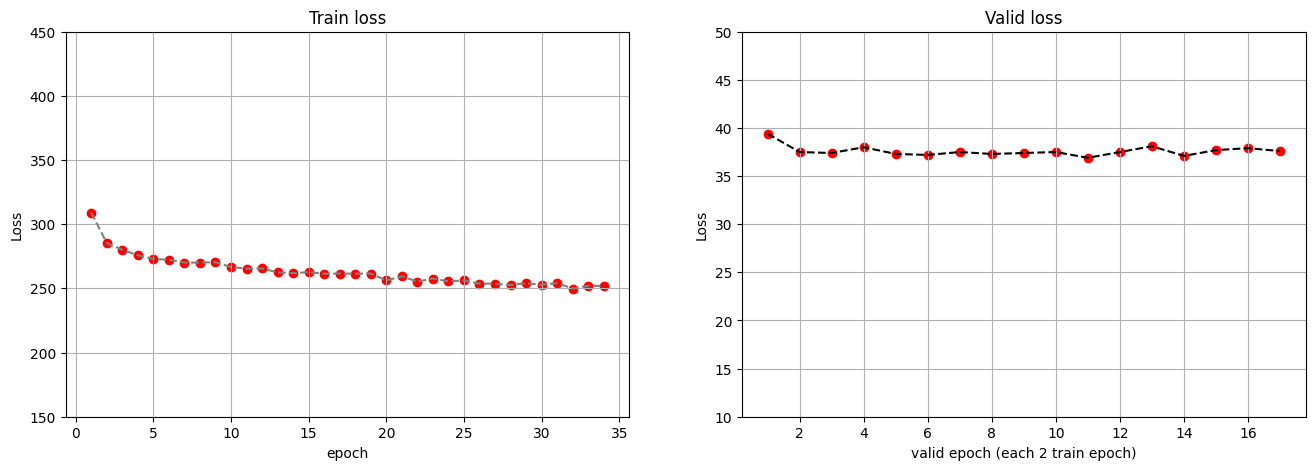

In [ ]:
plot_loss(np.round(resnet_pretrained_train_loss_list,1), np.round(resnet_pretrained_val_loss_list,1))

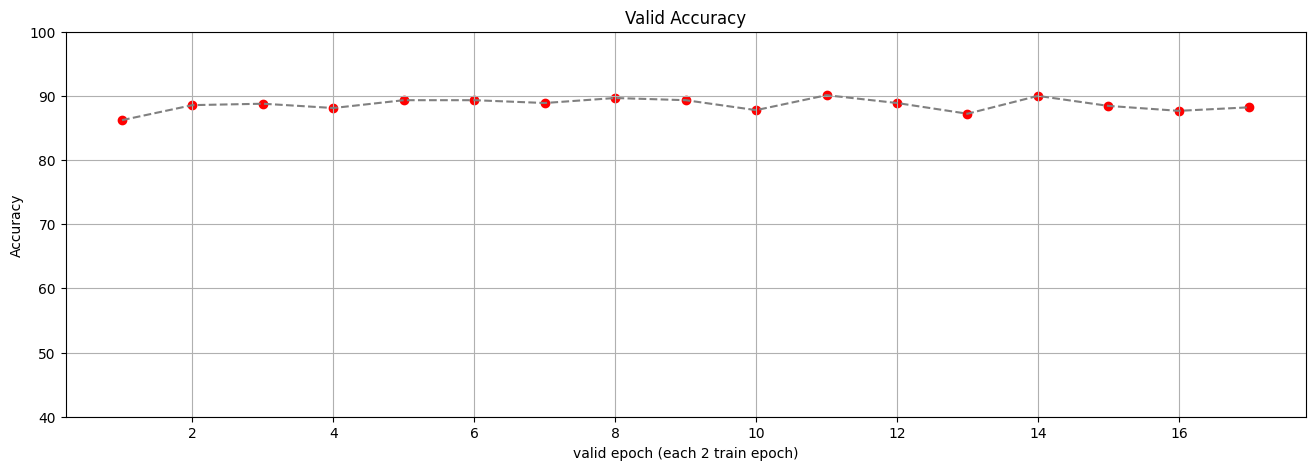

In [ ]:
plot_metrics(resnet_pretrained_val_acc_list)

In [ ]:
resnet_train_loss_str = list(map(str, resnet_pretrained_train_loss_list))
resnet_val_loss_str = list(map(str, resnet_pretrained_val_loss_list))
resnet_val_acc_str = list(map(str, resnet_pretrained_val_acc_list))

In [ ]:
with open("resnet34_metrics.txt", "w") as file:
  train_loss = " ".join(resnet_train_loss_str)
  train_loss = f"train_loss: {train_loss} \n"
  file.write(train_loss)

  val_loss = " ".join(resnet_val_loss_str)
  val_loss = f"val_loss: {val_loss} \n"
  file.write(val_loss)

  val_acc = " ".join(resnet_val_acc_str)
  val_acc = f"val_acc: {val_acc}"
  file.write(val_acc)

In [ ]:
#torch.save(model_pretrained.state_dict(), "/content/drive/MyDrive/swan_detection/resnet34_pretrained_model.pth") # epoch 10

In [ ]:
! cp resnet34_metrics.txt /content/drive/MyDrive/swan_detection/

# Pretrained ResNet34 Test

In [ ]:
device="cpu"
resnet34_model = resnet34(weights = ResNet34_Weights.DEFAULT).to(device)
resnet34_model.fc = linear_clf
resnet34_model.load_state_dict(torch.load('/content/drive/MyDrive/swan_detection/resnet34_pretrained_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
resnet34_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_accuracy = test_model(test_dataloader_resnet34, resnet34_model, criterion, device)

  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 89.28


In [ ]:
for batch in test_dataloader_resnet34:
  img, label = batch
  image = img[0]
  break

In [ ]:
image = torch.unsqueeze(image, dim=0)

In [ ]:
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
resnet34_model.eval()
soft = nn.Softmax(dim=1)
soft(resnet34_model(image))

tensor([[2.6321e-08, 1.0000e+00, 1.5128e-10]], grad_fn=<SoftmaxBackward0>)